In [1]:
# pylint: disable=too-many-lines

In [2]:
%pip install --extra-index-url https://artefact.skao.int/repository/pypi-internal/simple git+https://gitlab.com/ska-telescope/ska-low-csp-test 

Looking in indexes: https://pypi.org/simple, https://artefact.skao.int/repository/pypi-internal/simple
  Cloning https://gitlab.com/ska-telescope/ska-low-csp-test to /tmp/pip-req-build-zyrv_oda
  Running command git clone --filter=blob:none --quiet https://gitlab.com/ska-telescope/ska-low-csp-test /tmp/pip-req-build-zyrv_oda
  Resolved https://gitlab.com/ska-telescope/ska-low-csp-test to commit 43fda80ad8d01704a27eb09b19ef14c8ac940d2d
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


# Multiple execution blocks under TMC control

This notebook implements the following JAMA test case: [NB TMC Leaf node command and control with data path](https://skaoffice.jamacloud.com/perspective.req#/testCases/1155638?projectId=335)

Demonstrate the ability to run a sequence of IMAGING mode execution blocks (using different resources and configurations) and check that TMC delay model updates with changing stations between execution blocks

Note: the source delays in this notebook are supplied by TMC.  
Applying TMC delays at LOW CSP level utilises the TMC delay model calculation when applying tests. The correction provided by this model is the geometric station delays. Thus to verify that the delay polynomial is updated a sequence of execution blocks using different station configurations are executed in sequence and the reported TMC delays monitored.

All tests under TMC control and monitoring are approached as black box tests, where no direct LOW CSP LMC control or CBF simulators are implemented.


## TMC on the DS-PSI
An "execution block" in the scope of LOW CSP is the sequence of steps: assignResources->Configure->scan->Configure->scan->...->configure->scan->End->releaseResources

The difference between `assignResources` and `Configure` from the TMC point of view is how information is communicated between the surrounding subsystems. Mainly the difference is that DSP has to be set up with the whole execution block beforehand (unique "eb_id"), while MCCS and CSP is controlled on a scan by scan basis.     
The MCCS and CSP blocks in the Configuration JSONs have important parameters to set by LOW CSP during TMC command and control.     
The SDP block is a dummy required for the simulator.

## Test implementation summary
First Execution block (single scan):    
Station ids = [345, 347, 349, 351, 353, 355, 429, 431, 433]    
station labels = ["S8-1", "S8-3", "S8-5", "S9-1", "S9-3", "S9-5", "S10-1", "S10-3", "S10-5"]    
c1 = 180.0     
c2 = 50.0    

Second Execution block (dual scan):    
Station ids = [346, 348, 350, 352, 354, 356, 430, 432, 434]    
station labels = ["S8-2", "S8-4", "S8-6", "S9-2", "S9-4", "S9-6", "S10-2", "S10-4", "S10-6"]    
First Scan:    
c1 = 180.0    
c2 = 50.0    
Second Scan:    
c1 = 180.0    
c2 = 55.0    

Third Execution block (single scan):    
Station ids = [345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 429, 430, 431, 432, 433, 434]    
station labels = ['S8-1','S8-2','S8-3','S8-4','S8-5','S8-6','S9-1','S9-2','S9-3','S9-4','S9-5','S9-6','S10-1','S10-2','S10-3','S10-4','S10-5','S10-6']    
c1 = 180.0    
c2 = 50.0    

## Notebook setup


### Imports


In [3]:
import datetime
import itertools
import json
import logging
import os
import pprint
import socket
import sys
import time
import typing

import numpy as np
from io import BytesIO
from matplotlib import pyplot as plt
from PIL import Image

import tango
from IPython.display import Markdown, display, update_display
from ska_control_model import AdminMode, ObsState

from ska_low_csp_test.synchronisation import wait_for_condition
from ska_low_csp_test.cbf import visibilities
from ska_low_csp_test.domain import plotting

### TANGO / Kubernetes settings

Change the settings below to point to the correct Kubernetes namespace and TANGO database.


In [4]:
TANGO_DB_PORT = 10000
TANGO_DB_SVC = "ska-low-csp-databaseds"
TANGO_DB_NAMESPACE = "ska-low-csp-dev"
TANGO_DB_HOST = f"tango://{TANGO_DB_SVC}.{TANGO_DB_NAMESPACE}.svc.cluster.local:{TANGO_DB_PORT}"

### Notebook settings

Change the settings below to change the notebook behaviour.


In [5]:
SUBARRAY_ID = 1
STATION_BEAM_ID = 1

#### Configuration A: single scan


In [6]:
STATION_IDS_a = [345, 347, 349, 351, 353, 355, 429, 431, 433]

# allow any valid number of channels
CHANNEL_IDS_a = list(range(100, 108))

#### Configuration B: dual scan


In [7]:
STATION_IDS_b = [346, 348, 350, 352, 354, 356, 430, 432, 434]

# allow any valid number of channels
CHANNEL_IDS_b = list(range(100, 108))

#### Configuration C: single scan AA1 array


In [8]:
STATION_IDS_c = [345, 347, 349, 351, 353, 355, 429, 431, 433, 346, 348, 350, 352, 354, 356, 430, 432, 434]

# allow any valid number of channels
CHANNEL_IDS_c = list(range(100, 108))

#### Scan target coordinates


In [9]:
COORD_a = {"reference_frame": "ICRS", "c1": 180.0, "c2": 50.0}
COORD_b = {"reference_frame": "ICRS", "c1": 180.0, "c2": 55.0}

#### Settings to keep stable (or keep as pre-defined) for IMAGING mode

Notes:

- number of unique scan IDs must equal the number of scans in an execution block

Set a start scan ID and then simply increment for each scan to satisfy this criteria


In [10]:
# unique scan ID per scan (for the moment assume per source)
SCAN_ID_a = 1234  # pylint: disable=invalid-name
SCAN_ID_b = [1235, 1236]
SCAN_ID_c = 1237  # pylint: disable=invalid-name

In [11]:
# TMC config constants
EB_ID_a = "eb-test-20241012-00000"  # pylint: disable=invalid-name
EB_ID_b = "eb-test-20241012-00001"  # pylint: disable=invalid-name
EB_ID_c = "eb-test-20241012-00002"  # pylint: disable=invalid-name

#### System/setup settings


In [12]:
SUBSTATION_ID = 1

VIS_FW = "vis:0.1.0"

CNIC_FW_VERSION = "0.1.13"
CNIC_FW_SOURCE = "nexus"  # "nexus" or "gitlab"

SPS_SPEAD_VERSION = 3
SCAN_DURATION_S = 58.0 # 178.0

SDP_IP = "192.168.1.1"
FSP_ID = 1

### Proxy devices

In [13]:
csp_controller = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-csp/control/0")
csp_subarray = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-csp/subarray/{SUBARRAY_ID:02}")

tmc_central_node = tango.DeviceProxy(f"{TANGO_DB_HOST}/ska_low/tm_central/central_node")
tmc_subarray = tango.DeviceProxy(f"{TANGO_DB_HOST}/ska_low/tm_subarray_node/{SUBARRAY_ID}")
tmc_csp_subarray_leaf_node = tango.DeviceProxy(f"{TANGO_DB_HOST}/ska_low/tm_leaf_node/csp_subarray{SUBARRAY_ID:02}")

#### List of capture files


In [14]:
vis_pcap_files = []

### Logging setup

This will ensure everything will log to cell outputs.
IPython defaults to logging to `stderr` but the cells need to `stdout`.


In [15]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s : %(message)s",
    level=logging.INFO,
    stream=sys.stdout,
)

logger = logging.getLogger()

Convenience logic common to all LOW CSP notebooks


In [16]:
def format_port_status(connector_: tango.DeviceProxy) -> str:
    """Pretty-print P4 Port information to string.

    :param connector: CbfConnectorProxy Tango DeviceProxy wrapper
    :returns: formatted string, listing for each port:
        the port identifier,
        the port enable status,
        the port status,
        the configured port speed,
        the ingress packet count of the switch port,
        the egress packet count of the switch port
    """
    ports_ = get_port_status(connector_)

    return "\n".join(
        [
            "  ".join(
                [
                    "Port: {port[port]:>4}",
                    "Enable: {port[enable]!s:<5}",
                    "Up: {port[up]!s:<5}",
                    "Speed: {port[speed]:<5}",
                    "Rx: {port[packets_received]:8}",
                    "Tx: {port[packets_sent]:8}",
                ]
            ).format(port=each)
            for each in ports_.values()
        ]
    )


def get_port_status(connector_: tango.DeviceProxy) -> dict[str, dict[str, str]]:
    """Retrieve P4 Packet Counters.

    :returns: dictionary of the configured attributes and packet counts of each P4 switch port
    """
    port_status_json = connector_.PortStatus
    port_status_obj = json.loads(port_status_json)
    return {
        each["$PORT_NAME"]: {
            "port": each["$PORT_NAME"],
            "enable": each["$PORT_ENABLE"],
            "up": each["$PORT_UP"],
            "speed": each["$SPEED"],
            "packets_received": each["packets_received"],
            "packets_sent": each["packets_sent"],
        }
        for each in port_status_obj["Ports_Status"]
    }


def get_ports_counts(
    connector_: tango.DeviceProxy,
    ports_: list[str],
) -> dict[str, tuple[int, int]]:
    """
    Return the number of packets received and send through each P4 switch ports connected.

    :param connector: CbfConnectorProxy Tango DeviceProxy wrapper
    :param ports: a list of port identifiers to query
    :returns: a list a received and sent packet count tuple for each port
    """
    port_counts, port_status = {}, get_port_status(connector_)
    for port_ in ports_:
        try:
            status = port_status[port_]
            port_count = status["packets_received"], status["packets_sent"]
        except KeyError:
            # Unknown port
            port_count = (0, 0)
        port_counts[port_] = port_count
    return port_counts


def parse_hardware_connections(
    allocator: tango.DeviceProxy,  # pylint: disable = redefined-outer-name
) -> dict[str, str]:
    """Convert `allocator.hardware_connections` prop to `{ "serial": "port" }`.

    :param allocator: Allocator Tango device
    :returns: dictionary with FPGA device serial numbers as the keys, and the
    network switch port numbers as values
    """
    name = "hardware_connections"  # pylint: disable = redefined-outer-name
    prop = allocator.get_property(name)

    alveo_props = [each.split() for each in filter(lambda x: "alveo" in x, prop[name])]
    alveo_ports = [list(filter(lambda x: "alveo" in x or "port" in x, each)) for each in alveo_props]

    ports_ = list(itertools.chain.from_iterable(filter(lambda x: "port" in x, each) for each in alveo_ports))
    port_it = [each.strip("port=") for each in ports_]

    alveos = list(itertools.chain.from_iterable(filter(lambda x: "alveo" in x, each) for each in alveo_ports))
    alveo_it = [each.strip("alveo=") for each in alveos]

    return dict(zip(alveo_it, port_it))


def wait_for_attribute_value(
    device_: tango.DeviceProxy,
    attribute: str,
    value: typing.Any = True,
    failure_message: str = "Timed out waiting for attribute value",
    timeout_sec: int = 120,
) -> None:
    """
    Wait until an attribute has a certain value

    :param device: Tango device proxy with the attribute to check
    :param attribute: The name of the attribute
    :param value: Expected value (defaults to True)
    :param failure_message: Message for the exception on failure.
    Defaults to "Timed out waiting for attribute value".
    A note about duration is appended.
    :param timeout_sec: Approximate time-out period  in seconds (in reality
    it could be longer due to delays waiting for each attribute read)
    :raises RuntimeError: if expected value not seen before timing out
    """
    deadline = time.time() + timeout_sec
    poll_interval_seconds = 2
    while time.time() < deadline:
        try:
            if device_.read_attribute(attribute).value == value:
                break
        except tango.DevFailed as err_:
            raise AttributeError from err_

        time.sleep(poll_interval_seconds)
    else:
        raise RuntimeError(f"{failure_message} after {timeout_sec} sec")


def wait_for_device_response(
    device_: tango.DeviceProxy,
    failure_message: str = "Timed out waiting for device to respond",
    timeout_sec: int = 120,
) -> None:
    """
    Wait until a device responds.

    :param device: Tango device proxy to wait for
    :param failure_message: Message for the exception on failure.
    Defaults to "Timed out waiting for device to respond".
    A note about duration is appended.
    :param timeout_sec: Approximate time-out period in seconds
    :raises RuntimeError: if the device does not respond in time
    """
    deadline = time.time() + timeout_sec
    poll_interval_seconds = 2
    while time.time() < deadline:
        try:
            device_.ping()
            return
        except tango.ConnectionFailed:
            time.sleep(poll_interval_seconds)
    raise RuntimeError(f"{failure_message} after {timeout_sec} sec")

In [17]:
def pprint_delay_model(delay_model: dict):
    """Pretty-print TMC delay model values (for a single station)"""

    table = """
timestamp | station_id | xypos_coeff_ns
:- | :-: | :-
"""
    try:
        transient, ts_delay_model = pprint_delay_model.transient, pprint_delay_model.ts_delay_model
    except AttributeError:
        transient, ts_delay_model = {}, []

    ts_delay_model.append((datetime.datetime.now(), delay_model))

    for ts, delay_model_ in ts_delay_model:
        delays = delay_model_["station_beam_delays"]
        etc = ", ..." if len(delays) > 1 else ""
        station_id, coeffs = delays[0]["station_id"], delays[0]["xypol_coeffs_ns"]
        pp_coefs = ", ".join([f"{each:.5}" for each in coeffs])
        table += f"{ts} | {station_id}{etc} | [{pp_coefs}]{etc}\n"

    if not transient:
        display(Markdown(table), display_id=True, transient=transient)
    else:
        update_display(Markdown(table), display_id=transient["display_id"])

    pprint_delay_model.transient = transient
    pprint_delay_model.ts_delay_model = ts_delay_model[-4:]
#    pprint_delay_model.ts_delay_model = ts_delay_model[:]

## Set up CNIC

Use noise input for operational level tests via TMC in IMAGING mode


In [18]:
def cnic_config(station_ids: list, channel_ids: list) -> dict:
    """CNIC configuration JSON."""
    return {
        "sps_packet_version": SPS_SPEAD_VERSION,
        "stream_configs": [
            {
                "scan": 0,  # disregarded
                "subarray": SUBARRAY_ID,
                "station": station,
                "substation": SUBSTATION_ID,
                "frequency": channel,
                "beam": STATION_BEAM_ID,
                "sources": {
                    "x": [
                        {"tone": False, "seed": 1000, "scale": 4000},
                    ],
                    "y": [
                        {"tone": False, "seed": 1000, "scale": 4000},
                    ],
                },
            }
            for station in station_ids
            for channel in channel_ids
        ],
    }

In [19]:
cnic_vd = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-cbf/cnic/1")
# cnic_rx = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-cbf/cnic/2")
cnic_rx = cnic_vd  # duplex mode

for cnic in [cnic_rx, cnic_vd]:
    if not cnic.activePersonality == "cnic":
        logger.info("Programming CNIC %s", cnic.name())
        cnic.set_timeout_millis(300_000)
        cnic.SelectPersonality(
            json.dumps(
                {
                    "version": CNIC_FW_VERSION,
                    "source": CNIC_FW_SOURCE,
                    "memory": "4095Ms:4095Ms:4095Mi:4095Mi",
                }
            )
        )

    logger.info("Resetting CNIC %s", cnic.name())
    cnic.StopSourceDelays()
    cnic.CallMethod(json.dumps({"method": "stop_receive"}))
    cnic.CallMethod(json.dumps({"method": "reset"}))
    wait_for_attribute_value(cnic, "hbm_pktcontroller__duplex", False)
    cnic.hbm_pktcontroller__duplex = cnic_rx == cnic_vd
print("Done.")

2025-01-06 07:53:35,609 | INFO : Resetting CNIC low-cbf/cnic/1
2025-01-06 07:53:36,642 | INFO : Resetting CNIC low-cbf/cnic/1
Done.


### Fix configuration in TMC mocks

The SDP mocks created by TMC have hard-coded receive addresses, which incorrectly contain host names instead of IP addresses.
This causes an issue in LOW-CBF, so we manually overwrite them in the mock.

Related: [SKB-463](https://jira.skatelescope.org/browse/SKB-463)


In [20]:
pp = pprint.PrettyPrinter(indent=2)

sdp_subarray_mock = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-sdp/subarray/{SUBARRAY_ID:02}")

print("SDP receive addresses:")
receive_addresses = json.loads(sdp_subarray_mock.receiveAddresses)
pp.pprint(receive_addresses)

mutate = False  # pylint: disable=invalid-name
for key, val in receive_addresses.items():
    for each in val:
        if not isinstance(val[each], dict):  # nested dict vs nested list
            continue
        for idx, (num, host) in enumerate(receive_addresses[key][each]["host"]):
            try:
                socket.inet_aton(host)
            except socket.error:
                mutate = True  # pylint: disable=invalid-name
                receive_addresses[key][each]["host"][idx] = [num, SDP_IP]

if mutate:
    sdp_subarray_mock.SetDirectreceiveAddresses(json.dumps(receive_addresses))  # SKB-463 workaround

    print()
    print("Mutated SDP receive addresses:")
    pp.pprint(json.loads(sdp_subarray_mock.receiveAddresses))

SDP receive addresses:
{ 'calibration:b': { 'vis0': { 'function': 'visibilities',
                               'host': [ [ 0,
                                           'proc-pb-test-20220916-00000-test-receive-0.receive.test-sdp']],
                               'port': [[0, 9000, 1]]}},
  'science_A': { 'host': [[0, '192.168.0.1'], [2000, '192.168.0.1']],
                 'port': [[0, 9000, 1], [2000, 9000, 1]]},
  'target:a': { 'vis0': { 'function': 'visibilities',
                          'host': [ [ 0,
                                      'proc-pb-test-20220916-00000-test-receive-0.receive.test-sdp']],
                          'port': [[0, 9000, 1]]}}}

Mutated SDP receive addresses:
{ 'calibration:b': { 'vis0': { 'function': 'visibilities',
                               'host': [[0, '192.168.1.1']],
                               'port': [[0, 9000, 1]]}},
  'science_A': { 'host': [[0, '192.168.0.1'], [2000, '192.168.0.1']],
                 'port': [[0, 9000, 1], [2000, 90

## Initialise SUT

### Turn on telescope

**Some low level control is necessary when turning the telescope ON**  
First, turn on the CSP sub-system by toggling the `AdminMode` and waiting for everything to come online.  
Then, turn on the telescope through TMC by issuing the `TelescopeOn()` command.

The reason for the on command is that TMC is offline when started, this needs to be moved to online in order to communicate to the subsystems.


In [21]:
csp_controller.adminMode = AdminMode.OFFLINE
wait_for_condition(lambda: not csp_controller.isCommunicating, timeout_s=10.0)

In [22]:
csp_controller.adminMode = AdminMode.ONLINE
wait_for_condition(lambda: csp_controller.isCommunicating, timeout_s=10.0)
wait_for_condition(lambda: csp_subarray.state() == tango.DevState.ON, timeout_s=10.0)

In [23]:
tmc_central_node.TelescopeOn()
wait_for_condition(lambda: tmc_central_node.state() == tango.DevState.ON, timeout_s=10.0)
wait_for_condition(lambda: tmc_subarray.state() == tango.DevState.ON, timeout_s=10.0)

### Abort + Restart

Perform an `Abort` followed by `Restart` if the TMC subarray is not in an `EMPTY` state.


In [24]:
if tmc_subarray.obsState != ObsState.EMPTY:
    if tmc_subarray.obsState != ObsState.ABORTED:
        logger.info("Invoking Abort command on subarray")
        tmc_subarray.Abort()
        wait_for_condition(lambda: tmc_subarray.obsState == ObsState.ABORTED, timeout_s=60.0)

    logger.info("Invoking Restart command on subarray")
    tmc_subarray.Restart()
    wait_for_condition(lambda: tmc_subarray.obsState == ObsState.EMPTY, timeout_s=60.0)

## Execute first EB: signal scan using configuration A


### Assign Resources + Configure


The `sdp` block in the assign resources schema is a dummy from the LOW CSP point of view. The functionality related to this block lives outside the low csp leave node  
It is added as a dummy schema for the TMC SDP simulator and only needs to conform to schema validation needs, the data in the block is not used at LOW CSP level.


In [25]:
def tmc_assign_resources_json(eb_id: str) -> dict:
    """AssignResources JSON"""
    return {
        "interface": "https://schema.skao.int/ska-low-tmc-assignresources/4.0",
        "subarray_id": SUBARRAY_ID,
        "csp": {},
        "mccs": {  # dummy MCCS block
            "interface": "https://schema.skao.int/ska-low-mccs-controller-allocate/3.0",
            "subarray_beams": [],
        },
        "sdp": {  # dummy SDP block
            "resources": {"receive_nodes": 1},
            "execution_block": {
                "eb_id": eb_id,
                "max_length": 0.0,
                "beams": [],
                "channels": [],
                "context": {},
                "fields": [],
                "polarisations": [],
                "scan_types": [],
            },
        },
    }

In [26]:
TMC_ASSIGN_RESOURCES = tmc_assign_resources_json(EB_ID_a)

In [27]:
print(TMC_ASSIGN_RESOURCES)

{'interface': 'https://schema.skao.int/ska-low-tmc-assignresources/4.0', 'subarray_id': 1, 'csp': {}, 'mccs': {'interface': 'https://schema.skao.int/ska-low-mccs-controller-allocate/3.0', 'subarray_beams': []}, 'sdp': {'resources': {'receive_nodes': 1}, 'execution_block': {'eb_id': 'eb-test-20241012-00000', 'max_length': 0.0, 'beams': [], 'channels': [], 'context': {}, 'fields': [], 'polarisations': [], 'scan_types': []}}}


In [28]:
tmc_central_node.AssignResources(json.dumps(TMC_ASSIGN_RESOURCES))

[array([2], dtype=int32),
 ['1736150023.9229262_28068111923267_AssignResources']]

In [29]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.IDLE, timeout_s=10.0)

In [30]:
def tmc_configure_json(  # pylint: disable=too-many-arguments
    eb_id: str, station_ids: list, channel_ids: list, reference_frame: str, c1: float, c2: float
) -> dict:
    """Generate TMC CONFIGURATION with given sky coordinate."""
    return {
        "interface": "https://schema.skao.int/ska-low-tmc-configure/4.0",
        "csp": {
            "interface": "https://schema.skao.int/ska-low-csp-configure/3.2",
            "common": {
                "config_id": "sbi-mvp01-20200325-00001-science_A",
                "eb_id": eb_id,
            },
            "lowcbf": {
                "stations": {
                    "stns": [[station, SUBSTATION_ID] for station in station_ids],
                    "stn_beams": [
                        {
                            "beam_id": STATION_BEAM_ID,
                            "freq_ids": channel_ids,
                        }
                    ],
                },
                "vis": {
                    "fsp": {
                        "firmware": VIS_FW,
                        "fsp_ids": [FSP_ID],
                    },
                    "stn_beams": [
                        {
                            "stn_beam_id": STATION_BEAM_ID,
                            "integration_ms": 849,
                        }
                    ],
                },
            },
        },
        "mccs": {
            "subarray_beams": [
                {
                    "subarray_beam_id": STATION_BEAM_ID,
                    "update_rate": 0.0,
                    "apertures": [],
                    "logical_bands": [],
                    "sky_coordinates": {
                        "reference_frame": reference_frame,
                        "c1": c1,
                        "c2": c2,
                    },
                }
            ],
        },
        "sdp": {
            "interface": "https://schema.skao.int/ska-sdp-configure/0.4",
            "scan_type": "target:a",
        },
        "tmc": {
            "scan_duration": SCAN_DURATION_S,
        },
    }

In [31]:
TMC_CONFIGURE = tmc_configure_json(EB_ID_a, STATION_IDS_a, CHANNEL_IDS_a, **COORD_a)

In [32]:
tmc_subarray.Configure(json.dumps(TMC_CONFIGURE))

[array([2], dtype=int32), ['1736150027.0625682_108286023816736_Configure']]

In [33]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.READY, timeout_s=60.0)

### Set up P4 routing


In [34]:
cbf_allocator = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-cbf/allocator/0")
cbf_connector = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-cbf/connector/0")

In [35]:
fpga_ports = parse_hardware_connections(cbf_allocator)
logger.info("FPGA port mapping: %s", fpga_ports)

2025-01-06 07:54:11,223 | INFO : FPGA port mapping: {'XFL1SZ2IUU2I': '9/0', 'XFL1BB1SEWXK': '10/0', 'XFL1XXQM0FKW': '11/0', 'XFL1EG4H5YXY': '12/0'}


In [36]:
cbf_connector.UpdateSdpIpEntry(
    json.dumps({"sdp_ip": [{"src": {"ip": SDP_IP}, "dst": {"port": fpga_ports[cnic_rx.serialnumber]}}]})
)

[array([0], dtype=int32), ['SDP_IP_Routes_Updated']]

In [37]:
logger.info("P4 basic routing table: %s", cbf_connector.BasicRoutingTable)
logger.info("P4 PSR routing table: %s", cbf_connector.PsrRoutingTable)
logger.info("P4 SDP IP routing table: %s", cbf_connector.SdpIpRoutingTable)
logger.info("P4 SDP MAC routing table: %s", cbf_connector.SdpMacRoutingTable)
logger.info("P4 SPEAD Multiplier routing table: %s", cbf_connector.SpeadMultiplierRoutingTable)
logger.info("P4 SPEAD Unicast routing table: %s", cbf_connector.SpeadUnicastRoutingTable)

2025-01-06 07:54:11,503 | INFO : P4 basic routing table: {"Basic": [{"ingress port": "0/0", "port": "0/0"}]}
2025-01-06 07:54:11,506 | INFO : P4 PSR routing table: {"PSR": [{"Beam": "1", "port": "1/0"}]}
2025-01-06 07:54:11,508 | INFO : P4 SDP IP routing table: {"SDP_IP": [{"IP_Address": "0.0.0.0", "port": "0/0"}]}
2025-01-06 07:54:11,510 | INFO : P4 SDP MAC routing table: {"SDP_MAC": [{"IP_Address": "0.0.0.0", "MAC": "00:00:00:00:00:00"}]}
2025-01-06 07:54:11,512 | INFO : P4 SPEAD Multiplier routing table: {"Spead": [{"Frequency": 0, "Beam": 0, "Sub_array": 0, "session": 0}]}
2025-01-06 07:54:11,515 | INFO : P4 SPEAD Unicast routing table: {"Spead": [{"Frequency": "100", "Beam": "1", "Sub_array": "1", "port": "11/0"}, {"Frequency": "101", "Beam": "1", "Sub_array": "1", "port": "11/0"}, {"Frequency": "102", "Beam": "1", "Sub_array": "1", "port": "11/0"}, {"Frequency": "103", "Beam": "1", "Sub_array": "1", "port": "11/0"}, {"Frequency": "104", "Beam": "1", "Sub_array": "1", "port": "11/

In [38]:
correlator_serial = json.loads(cbf_allocator.fsps)[f"fsp_{FSP_ID:02}"][0]
print("Correlator FPGA has serial number", correlator_serial)

correlator_fqdn = json.loads(cbf_allocator.procDevFqdn)[correlator_serial]
print("Correlator FPGA TANGO device:", correlator_fqdn)

correlator = tango.DeviceProxy(f"{TANGO_DB_HOST}/{correlator_fqdn}")

Correlator FPGA has serial number XFL1XXQM0FKW
Correlator FPGA TANGO device: low-cbf/processor/0.0.2


In [39]:
cbf_connector.ResetPortStatistics()

[array([0], dtype=int32), ['Ports Statistics Reset']]

In [40]:
serialno_port = parse_hardware_connections(cbf_allocator)
print(serialno_port)

cnic_vd_port = serialno_port[cnic_vd.serialnumber]
print("CNIC VD is connected to P4 port", cnic_vd_port)

correlator_port = serialno_port[correlator_serial]
print("Correlator FPGA is connected to P4 port", correlator_port)

cnic_rx_port = serialno_port[cnic_rx.serialnumber]
print("CNIC RX is connected to P4 port", cnic_rx_port)

ports = [cnic_vd_port, correlator_port, cnic_rx_port]

for name, cnic, port in ("Tx", cnic_vd, cnic_vd_port), ("XF", correlator, correlator_port), ("Rx", cnic_rx, cnic_rx_port):
    print(f"{name}: port: {port:>4}, S/N: {cnic.serialnumber}, {cnic.name()}")

print()
print(f"P4 port status:\n{format_port_status(cbf_connector)}")
print()
print("Routing tables:")
print(f"  Arp:               {cbf_connector.ArpRoutingTable}")
print(f"  Basic:             {cbf_connector.BasicRoutingTable}")
print(f"  PSR:               {cbf_connector.PsrRoutingTable}")
print(f"  SDP IP:            {cbf_connector.SdpIpRoutingTable}")
print(f"  SDP MAC:           {cbf_connector.SdpMacRoutingTable}")
print(f"  SPEAD Mulftiplier: {cbf_connector.SpeadMultiplierRoutingTable}")
print(f"  SPEAD Unicast:     {cbf_connector.SpeadUnicastRoutingTable}")

{'XFL1SZ2IUU2I': '9/0', 'XFL1BB1SEWXK': '10/0', 'XFL1XXQM0FKW': '11/0', 'XFL1EG4H5YXY': '12/0'}
CNIC VD is connected to P4 port 9/0
Correlator FPGA is connected to P4 port 11/0
CNIC RX is connected to P4 port 9/0
Tx: port:  9/0, S/N: XFL1SZ2IUU2I, low-cbf/cnic/1
XF: port: 11/0, S/N: XFL1XXQM0FKW, low-cbf/processor/0.0.2
Rx: port:  9/0, S/N: XFL1SZ2IUU2I, low-cbf/cnic/1

P4 port status:
Port:  1/0  Enable: True   Up: True   Speed: 100G   Rx:        0  Tx:        0
Port:  9/0  Enable: True   Up: True   Speed: 100G   Rx:        0  Tx:        0
Port: 10/0  Enable: True   Up: True   Speed: 100G   Rx:        0  Tx:        0
Port: 11/0  Enable: True   Up: False  Speed: 100G   Rx:        0  Tx:        0
Port: 12/0  Enable: True   Up: False  Speed: 100G   Rx:        0  Tx:        0
Port: 32/0  Enable: True   Up: False  Speed: 100G   Rx:        0  Tx:        0

Routing tables:
  Arp:               {"ARP": [{"IP": "0.0.0.0", "MAC": "00:00:00:00:00:00"}]}
  Basic:             {"Basic": [{"ingress 

### Scan


#### Configure CNIC Rx

Configure the CNIC Rx to capture visibility data.


In [41]:
CNIC_RX_PACKET_COUNT = 9_999_999  # many packets -- we will end the capture manually
CNIC_RX_MINIMUM_PACKET_SIZE = 200  # to avoid END packets

In [42]:
pcap_file_name = datetime.datetime.now().strftime("%Y%m%d_%H%M%S_") + "vis-via-tmc.pcap"
CNIC_RX_PCAP_FILE_PATH = os.path.join("/test-data", pcap_file_name)

cnic_rx.CallMethod(
    json.dumps(
        {
            "method": "receive_pcap",
            "arguments": {
                "out_filename": CNIC_RX_PCAP_FILE_PATH,
                "packet_size": CNIC_RX_MINIMUM_PACKET_SIZE,
                "n_packets": CNIC_RX_PACKET_COUNT,
            },
        }
    )
)

'None'

#### Configure CNIC-VD

Configure the CNIC-VD and point it to the source delays from TMC.
The CNIC-VD will automatically start transmitting once it receives delays.


In [43]:
CNIC_VD_CONFIG = cnic_config(STATION_IDS_a, CHANNEL_IDS_a)

In [44]:
cnic_vd.ConfigureVirtualDigitiser(json.dumps(CNIC_VD_CONFIG))

In [45]:
TM_SOURCE_DELAYS = {
    SUBARRAY_ID: {
        STATION_BEAM_ID: [
            f"ska_low/tm_leaf_node/csp_subarray{SUBARRAY_ID:02}",
            "DelayModel",
        ]
    }
}

print(TM_SOURCE_DELAYS)

{1: {1: ['ska_low/tm_leaf_node/csp_subarray01', 'DelayModel']}}


#### Ensure valid delaypoly before enabling data generation

This is a limitation of the simulated environment and may take up to 5 minutes.
CNIC-VD waits for delaypoly update to generate appropriate signals

In [46]:
proxy, attr = tmc_csp_subarray_leaf_node, "delayModel"
while True:
    value = getattr(proxy, attr, None)
    if value is not None:
        initial_poly_time = json.loads(value)["start_validity_sec"]
        print("initial_poly_time:", initial_poly_time)
        start_time = time.time()
        break

while True:
    value = getattr(proxy, attr, None)
    if value is not None:
        cur_poly_time = json.loads(value)["start_validity_sec"]
        if cur_poly_time != initial_poly_time:
            print()
            break
    print(end=".")
    time.sleep(2)

print(f"{int(time.time()-start_time)} sec, cur_poly_time: {cur_poly_time}")

initial_poly_time: 789465866.8347931
...........................................................................................................................................
278 sec, cur_poly_time: 789466166.8347931


In [47]:
cnic_vd.StartTmSourceDelays(json.dumps(TM_SOURCE_DELAYS))

#### Perform Scan


In [48]:
SCAN_ID = SCAN_ID_a

In [49]:
tmc_subarray.Scan(
    json.dumps(
        {
            "interface": "https://schema.skao.int/ska-tmc-scan/4.0",
            "scan_id": SCAN_ID,
        }
    )
)

[array([2], dtype=int32), ['1736150332.0213852_264809992938993_Scan']]

In [50]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.SCANNING, timeout_s=10.0)

##### Print delay coefficients provided by TMC


In [51]:
while tmc_subarray.obsState == ObsState.SCANNING:
    pprint_delay_model(json.loads(tmc_csp_subarray_leaf_node.DelayModel))
    time.sleep(5)

print("Done.")


timestamp | station_id | xypos_coeff_ns
:- | :-: | :-
2025-01-06 07:59:27.138513 | 345, ... | [2672.6, 0.45847, 1.3925e-05, -4.0632e-10, -6.1717e-15, 1.1016e-19], ...
2025-01-06 07:59:32.146573 | 345, ... | [2672.6, 0.45847, 1.3925e-05, -4.0632e-10, -6.1717e-15, 1.1016e-19], ...
2025-01-06 07:59:37.156449 | 345, ... | [2672.6, 0.45847, 1.3925e-05, -4.0632e-10, -6.1717e-15, 1.1016e-19], ...
2025-01-06 07:59:42.166630 | 345, ... | [2672.6, 0.45847, 1.3925e-05, -4.0632e-10, -6.1717e-15, 1.1016e-19], ...
2025-01-06 07:59:47.177704 | 345, ... | [2672.6, 0.45847, 1.3925e-05, -4.0632e-10, -6.1717e-15, 1.1016e-19], ...


Done.


#### Wait for scan to finish and tear down subarray

The scan should finish automatically, after which the subarray becomes `READY` again.
After that, deconfigure and release resources.


In [52]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.READY, timeout_s=10.0)

In [53]:
tmc_subarray.End()

[array([2], dtype=int32), ['1736150392.2144852_113434229068762_End']]

In [54]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.IDLE, timeout_s=10.0)

In [55]:
tmc_central_node.ReleaseResources(
    json.dumps(
        {
            "interface": "https://schema.skao.int/ska-tmc-releaseresources/3.0",
            "subarray_id": SUBARRAY_ID,
            "release_all": True,
        }
    )
)

[array([2], dtype=int32),
 ['1736150395.2724397_140872644694488_ReleaseResources']]

In [56]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.EMPTY, timeout_s=10.0)

#### Wait for capture to finish


In [57]:
cnic_rx.CallMethod(json.dumps({"method": "stop_receive"}))

'None'

In [58]:
logger.info("Target number of packets to capture: %d", CNIC_RX_PACKET_COUNT)

count = 0  # pylint: disable=invalid-name
while not cnic_rx.finished_receive:
    packets_received = cnic_rx.hbm_pktcontroller__rx_packet_count
    logger.info("Packets received: %d", cnic_rx.hbm_pktcontroller__rx_packet_count)
    time.sleep(5)
    count += 1
    if count > 20:
        logger.warning("Still not finished receiving, something is wrong")
        break
else:
    logger.info("Finished writing PCAP file: %s", CNIC_RX_PCAP_FILE_PATH)
    vis_pcap_files.append(CNIC_RX_PCAP_FILE_PATH)

2025-01-06 07:59:58,360 | INFO : Target number of packets to capture: 9999999
2025-01-06 07:59:58,433 | INFO : Packets received: 79419
2025-01-06 08:00:03,442 | INFO : Finished writing PCAP file: /test-data/20250106_075411_vis-via-tmc.pcap


In [59]:
print("CNIC VD is connected to P4 port", cnic_vd_port)
print("Correlator FPGA is connected to P4 port", correlator_port)
print("CNIC RX is connected to P4 port", cnic_rx_port)

print()
print(f"P4 port status:\n{format_port_status(cbf_connector)}")
print()

CNIC VD is connected to P4 port 9/0
Correlator FPGA is connected to P4 port 11/0
CNIC RX is connected to P4 port 9/0

P4 port status:
Port:  1/0  Enable: True   Up: True   Speed: 100G   Rx:    22882  Tx:    16718
Port:  9/0  Enable: True   Up: True   Speed: 100G   Rx:  2360255  Tx:   103089
Port: 10/0  Enable: True   Up: True   Speed: 100G   Rx:     5630  Tx:    22519
Port: 11/0  Enable: True   Up: True   Speed: 100G   Rx:    86017  Tx:  2033834
Port: 12/0  Enable: True   Up: False  Speed: 100G   Rx:        0  Tx:        0
Port: 32/0  Enable: True   Up: False  Speed: 100G   Rx:        0  Tx:        0



In [60]:
cnic_vd.StopSourceDelays()

## Execute second EB: dual scan using configuration B


### Assign Resources + Configure


In [61]:
TMC_ASSIGN_RESOURCES = tmc_assign_resources_json(EB_ID_b)

In [62]:
print(TMC_ASSIGN_RESOURCES)

{'interface': 'https://schema.skao.int/ska-low-tmc-assignresources/4.0', 'subarray_id': 1, 'csp': {}, 'mccs': {'interface': 'https://schema.skao.int/ska-low-mccs-controller-allocate/3.0', 'subarray_beams': []}, 'sdp': {'resources': {'receive_nodes': 1}, 'execution_block': {'eb_id': 'eb-test-20241012-00001', 'max_length': 0.0, 'beams': [], 'channels': [], 'context': {}, 'fields': [], 'polarisations': [], 'scan_types': []}}}


In [63]:
tmc_central_node.AssignResources(json.dumps(TMC_ASSIGN_RESOURCES))

[array([2], dtype=int32),
 ['1736150404.6933427_168714877526277_AssignResources']]

In [64]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.IDLE, timeout_s=10.0)

In [65]:
TMC_CONFIGURE = tmc_configure_json(EB_ID_b, STATION_IDS_b, CHANNEL_IDS_b, **COORD_a)

In [66]:
tmc_subarray.Configure(json.dumps(TMC_CONFIGURE))

[array([2], dtype=int32), ['1736150407.7950299_50743460832711_Configure']]

In [67]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.READY, timeout_s=60.0)

### First scan


In [68]:
cbf_connector.UpdateSdpIpEntry(
    json.dumps({"sdp_ip": [{"src": {"ip": SDP_IP}, "dst": {"port": fpga_ports[cnic_rx.serialnumber]}}]})
)

[array([0], dtype=int32), ['SDP_IP_Routes_Updated']]

#### Configure CNIC Rx

Configure the CNIC Rx to capture visibility data.


In [69]:
pcap_file_name = datetime.datetime.now().strftime("%Y%m%d_%H%M%S_") + "vis-via-tmc.pcap"
CNIC_RX_PCAP_FILE_PATH = os.path.join("/test-data", pcap_file_name)

cnic_rx.CallMethod(
    json.dumps(
        {
            "method": "receive_pcap",
            "arguments": {
                "out_filename": CNIC_RX_PCAP_FILE_PATH,
                "packet_size": CNIC_RX_MINIMUM_PACKET_SIZE,
                "n_packets": CNIC_RX_PACKET_COUNT,
            },
        }
    )
)

'None'

#### Configure CNIC-VD

Configure the CNIC-VD and point it to the source delays from TMC.
The CNIC-VD will automatically start transmitting once it receives delays.


In [70]:
CNIC_VD_CONFIG = cnic_config(STATION_IDS_b, CHANNEL_IDS_b)

In [71]:
cnic_vd.ConfigureVirtualDigitiser(json.dumps(CNIC_VD_CONFIG))

In [72]:
TM_SOURCE_DELAYS = {
    SUBARRAY_ID: {
        STATION_BEAM_ID: [
            f"ska_low/tm_leaf_node/csp_subarray{SUBARRAY_ID:02}",
            "DelayModel",
        ]
    }
}

print(TM_SOURCE_DELAYS)

{1: {1: ['ska_low/tm_leaf_node/csp_subarray01', 'DelayModel']}}


#### Ensure valid delaypoly before enabling data generation

This is a limitation of the simulated environment and may take up to 5 minutes.
CNIC-VD waits for delaypoly update to generate appropriate signals

In [73]:
proxy, attr = tmc_csp_subarray_leaf_node, "delayModel"
while True:
    value = getattr(proxy, attr, None)
    if value is not None:
        initial_poly_time = json.loads(value)["start_validity_sec"]
        print("initial_poly_time:", initial_poly_time)
        start_time = time.time()
        break

while True:
    value = getattr(proxy, attr, None)
    if value is not None:
        cur_poly_time = json.loads(value)["start_validity_sec"]
        if cur_poly_time != initial_poly_time:
            print()
            break
    print(end=".")
    time.sleep(2)

print(f"{int(time.time()-start_time)} sec, cur_poly_time: {cur_poly_time}")

initial_poly_time: 0.1
...............................................................................................
190 sec, cur_poly_time: 789466245.2874229


In [74]:
cnic_vd.StartTmSourceDelays(json.dumps(TM_SOURCE_DELAYS))

#### Perform first scan


In [75]:
SCAN_ID = SCAN_ID_b[0]

In [76]:
tmc_subarray.Scan(
    json.dumps(
        {
            "interface": "https://schema.skao.int/ska-tmc-scan/4.0",
            "scan_id": SCAN_ID,
        }
    )
)

[array([2], dtype=int32), ['1736150630.9931562_242587557603964_Scan']]

In [77]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.SCANNING, timeout_s=10.0)

##### Print delay coefficients provided by TMC


In [78]:
pprint_delay_model.transient, pprint_delay_model.ts_delay_model = {}, []

In [79]:
while tmc_subarray.obsState == ObsState.SCANNING:
    pprint_delay_model(json.loads(tmc_csp_subarray_leaf_node.DelayModel))
    time.sleep(5)

print("Done.")


timestamp | station_id | xypos_coeff_ns
:- | :-: | :-
2025-01-06 08:04:26.113421 | 346, ... | [2726.2, 0.45405, 1.3763e-05, -4.024e-10, -6.1e-15, 1.0908e-19], ...
2025-01-06 08:04:31.122450 | 346, ... | [2726.2, 0.45405, 1.3763e-05, -4.024e-10, -6.1e-15, 1.0908e-19], ...
2025-01-06 08:04:36.130607 | 346, ... | [2726.2, 0.45405, 1.3763e-05, -4.024e-10, -6.1e-15, 1.0908e-19], ...
2025-01-06 08:04:41.140604 | 346, ... | [2726.2, 0.45405, 1.3763e-05, -4.024e-10, -6.1e-15, 1.0908e-19], ...
2025-01-06 08:04:46.151277 | 346, ... | [2726.2, 0.45405, 1.3763e-05, -4.024e-10, -6.1e-15, 1.0908e-19], ...


Done.


In [80]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.READY, timeout_s=10.0)

### Configure second scan


In [81]:
TMC_CONFIGURE = tmc_configure_json(EB_ID_b, STATION_IDS_b, CHANNEL_IDS_b, **COORD_b)

In [82]:
tmc_subarray.Configure(json.dumps(TMC_CONFIGURE))

[array([2], dtype=int32), ['1736150691.1946723_159934599597989_Configure']]

In [83]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.READY, timeout_s=60.0)

#### Perform second scan


In [84]:
SCAN_ID = SCAN_ID_b[1]

In [85]:
tmc_subarray.Scan(
    json.dumps(
        {
            "interface": "https://schema.skao.int/ska-tmc-scan/4.0",
            "scan_id": SCAN_ID,
        }
    )
)

[array([2], dtype=int32), ['1736150694.2705226_26163636698293_Scan']]

In [86]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.SCANNING, timeout_s=10.0)

##### Print delay coefficients provided by TMC


In [87]:
pprint_delay_model.transient, pprint_delay_model.ts_delay_model = {}, []

In [88]:
while tmc_subarray.obsState == ObsState.SCANNING:
    pprint_delay_model(json.loads(tmc_csp_subarray_leaf_node.DelayModel))
    time.sleep(5)

print("Done.")


timestamp | station_id | xypos_coeff_ns
:- | :-: | :-
2025-01-06 08:05:29.422174 | 346, ... | [2726.2, 0.45405, 1.3763e-05, -4.024e-10, -6.1e-15, 1.0908e-19], ...
2025-01-06 08:05:34.430689 | 346, ... | [2726.2, 0.45405, 1.3763e-05, -4.024e-10, -6.1e-15, 1.0908e-19], ...
2025-01-06 08:05:39.441788 | 346, ... | [2726.2, 0.45405, 1.3763e-05, -4.024e-10, -6.1e-15, 1.0908e-19], ...
2025-01-06 08:05:44.452819 | 346, ... | [2726.2, 0.45405, 1.3763e-05, -4.024e-10, -6.1e-15, 1.0908e-19], ...
2025-01-06 08:05:49.463509 | 346, ... | [2726.2, 0.45405, 1.3763e-05, -4.024e-10, -6.1e-15, 1.0908e-19], ...


Done.


### Wait for scan to finish and tear down subarray

The scan should finish automatically, after which the subarray becomes `READY` again.
After that, deconfigure and release resources.


In [89]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.READY, timeout_s=10.0)

In [90]:
tmc_subarray.End()

[array([2], dtype=int32), ['1736150754.5032518_95178997440557_End']]

In [91]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.IDLE, timeout_s=10.0)

In [92]:
tmc_central_node.ReleaseResources(
    json.dumps(
        {
            "interface": "https://schema.skao.int/ska-tmc-releaseresources/3.0",
            "subarray_id": SUBARRAY_ID,
            "release_all": True,
        }
    )
)

[array([2], dtype=int32),
 ['1736150757.6663795_280125875292083_ReleaseResources']]

In [93]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.EMPTY, timeout_s=10.0)

### Wait for capture to finish


In [94]:
cnic_rx.CallMethod(json.dumps({"method": "stop_receive"}))

'None'

In [95]:
logger.info("Target number of packets to capture: %d", CNIC_RX_PACKET_COUNT)

count = 0  # pylint: disable=invalid-name
while not cnic_rx.finished_receive:
    packets_received = cnic_rx.hbm_pktcontroller__rx_packet_count
    logger.info("Packets received: %d", cnic_rx.hbm_pktcontroller__rx_packet_count)
    time.sleep(5)
    count += 1
    if count > 20:
        logger.warning("Still not finished receiving, something is wrong")
        break
else:
    logger.info("Finished writing PCAP file: %s", CNIC_RX_PCAP_FILE_PATH)
    vis_pcap_files.append(CNIC_RX_PCAP_FILE_PATH)

2025-01-06 08:06:00,755 | INFO : Target number of packets to capture: 9999999
2025-01-06 08:06:00,828 | INFO : Packets received: 79419
2025-01-06 08:06:05,836 | INFO : Finished writing PCAP file: /test-data/20250106_080039_vis-via-tmc.pcap


In [96]:
print("CNIC VD is connected to P4 port", cnic_vd_port)
print("Correlator FPGA is connected to P4 port", correlator_port)
print("CNIC RX is connected to P4 port", cnic_rx_port)

print()
print(f"P4 port status:\n{format_port_status(cbf_connector)}")
print()

CNIC VD is connected to P4 port 9/0
Correlator FPGA is connected to P4 port 11/0
CNIC RX is connected to P4 port 9/0

P4 port status:
Port:  1/0  Enable: True   Up: True   Speed: 100G   Rx:    46818  Tx:    34299
Port:  9/0  Enable: True   Up: True   Speed: 100G   Rx:  6833915  Tx:   207220
Port: 10/0  Enable: True   Up: True   Speed: 100G   Rx:    11460  Tx:    46080
Port: 11/0  Enable: True   Up: True   Speed: 100G   Rx:   253204  Tx:  6165894
Port: 12/0  Enable: True   Up: False  Speed: 100G   Rx:        0  Tx:        0
Port: 32/0  Enable: True   Up: False  Speed: 100G   Rx:        0  Tx:        0



In [97]:
cnic_vd.StopSourceDelays()

## Execute third (last) EB: single scan using configuration C


### Assign Resources + Configure


In [98]:
TMC_ASSIGN_RESOURCES = tmc_assign_resources_json(EB_ID_c)

In [99]:
print(TMC_ASSIGN_RESOURCES)

{'interface': 'https://schema.skao.int/ska-low-tmc-assignresources/4.0', 'subarray_id': 1, 'csp': {}, 'mccs': {'interface': 'https://schema.skao.int/ska-low-mccs-controller-allocate/3.0', 'subarray_beams': []}, 'sdp': {'resources': {'receive_nodes': 1}, 'execution_block': {'eb_id': 'eb-test-20241012-00002', 'max_length': 0.0, 'beams': [], 'channels': [], 'context': {}, 'fields': [], 'polarisations': [], 'scan_types': []}}}


In [100]:
tmc_central_node.AssignResources(json.dumps(TMC_ASSIGN_RESOURCES))

[array([2], dtype=int32), ['1736150766.9902844_8099001163174_AssignResources']]

In [101]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.IDLE, timeout_s=10.0)

In [102]:
TMC_CONFIGURE = tmc_configure_json(EB_ID_c, STATION_IDS_c, CHANNEL_IDS_c, **COORD_a)

In [103]:
tmc_subarray.Configure(json.dumps(TMC_CONFIGURE))

[array([2], dtype=int32), ['1736150770.0620227_65342506493257_Configure']]

In [104]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.READY, timeout_s=60.0)

### Scan


In [105]:
cbf_connector.UpdateSdpIpEntry(
    json.dumps({"sdp_ip": [{"src": {"ip": SDP_IP}, "dst": {"port": fpga_ports[cnic_rx.serialnumber]}}]})
)

[array([0], dtype=int32), ['SDP_IP_Routes_Updated']]

#### Configure CNIC Rx

Configure the CNIC Rx to capture visibility data.


In [106]:
pcap_file_name = datetime.datetime.now().strftime("%Y%m%d_%H%M%S_") + "vis-via-tmc.pcap"
CNIC_RX_PCAP_FILE_PATH = os.path.join("/test-data", pcap_file_name)

cnic_rx.CallMethod(
    json.dumps(
        {
            "method": "receive_pcap",
            "arguments": {
                "out_filename": CNIC_RX_PCAP_FILE_PATH,
                "packet_size": CNIC_RX_MINIMUM_PACKET_SIZE,
                "n_packets": CNIC_RX_PACKET_COUNT,
            },
        }
    )
)

'None'

#### Configure CNIC-VD

Configure the CNIC-VD and point it to the source delays from TMC.
The CNIC-VD will automatically start transmitting once it receives delays.


In [107]:
CNIC_VD_CONFIG = cnic_config(STATION_IDS_c, CHANNEL_IDS_c)

In [108]:
cnic_vd.ConfigureVirtualDigitiser(json.dumps(CNIC_VD_CONFIG))

In [109]:
TM_SOURCE_DELAYS = {
    SUBARRAY_ID: {
        STATION_BEAM_ID: [
            f"ska_low/tm_leaf_node/csp_subarray{SUBARRAY_ID:02}",
            "DelayModel",
        ]
    }
}

print(TM_SOURCE_DELAYS)

{1: {1: ['ska_low/tm_leaf_node/csp_subarray01', 'DelayModel']}}


#### Ensure valid delaypoly before enabling data generation

This is a limitation of the simulated environment and may take up to 5 minutes.
CNIC-VD waits for delaypoly update to generate appropriate signals

In [110]:
proxy, attr = tmc_csp_subarray_leaf_node, "delayModel"
while True:
    value = getattr(proxy, attr, None)
    if value is not None:
        initial_poly_time = json.loads(value)["start_validity_sec"]
        print("initial_poly_time:", initial_poly_time)
        start_time = time.time()
        break

while True:
    value = getattr(proxy, attr, None)
    if value is not None:
        cur_poly_time = json.loads(value)["start_validity_sec"]
        if cur_poly_time != initial_poly_time:
            print()
            break
    print(end=".")
    time.sleep(2)

print(f"{int(time.time()-start_time)} sec, cur_poly_time: {cur_poly_time}")

initial_poly_time: 0.1
..........................................................................
148 sec, cur_poly_time: 789466607.624898


In [111]:
cnic_vd.StartTmSourceDelays(json.dumps(TM_SOURCE_DELAYS))

#### Perform scan


In [112]:
SCAN_ID = SCAN_ID_c

In [113]:
tmc_subarray.Scan(
    json.dumps(
        {
            "interface": "https://schema.skao.int/ska-tmc-scan/4.0",
            "scan_id": SCAN_ID,
        }
    )
)

[array([2], dtype=int32), ['1736150932.394467_104603877436285_Scan']]

In [114]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.SCANNING, timeout_s=10.0)

##### Print delay coefficients provided by TMC


In [115]:
pprint_delay_model.transient, pprint_delay_model.ts_delay_model = {}, []

In [116]:
while tmc_subarray.obsState == ObsState.SCANNING:
    pprint_delay_model(json.loads(tmc_csp_subarray_leaf_node.DelayModel))
    time.sleep(5)

print("Done.")


timestamp | station_id | xypos_coeff_ns
:- | :-: | :-
2025-01-06 08:09:27.514395 | 345, ... | [2877.4, 0.47051, 1.3381e-05, -4.1699e-10, -5.9304e-15, 1.1292e-19], ...
2025-01-06 08:09:32.522883 | 345, ... | [2877.4, 0.47051, 1.3381e-05, -4.1699e-10, -5.9304e-15, 1.1292e-19], ...
2025-01-06 08:09:37.530599 | 345, ... | [2877.4, 0.47051, 1.3381e-05, -4.1699e-10, -5.9304e-15, 1.1292e-19], ...
2025-01-06 08:09:42.542896 | 345, ... | [2877.4, 0.47051, 1.3381e-05, -4.1699e-10, -5.9304e-15, 1.1292e-19], ...
2025-01-06 08:09:47.549589 | 345, ... | [2877.4, 0.47051, 1.3381e-05, -4.1699e-10, -5.9304e-15, 1.1292e-19], ...


Done.


#### Wait for scan to finish and tear down subarray

The scan should finish automatically, after which the subarray becomes `READY` again.
After that, deconfigure and release resources.


In [117]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.READY, timeout_s=10.0)

In [118]:
tmc_subarray.End()

[array([2], dtype=int32), ['1736150992.5847125_259791473491521_End']]

In [119]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.IDLE, timeout_s=10.0)

In [120]:
tmc_central_node.ReleaseResources(
    json.dumps(
        {
            "interface": "https://schema.skao.int/ska-tmc-releaseresources/3.0",
            "subarray_id": SUBARRAY_ID,
            "release_all": True,
        }
    )
)

[array([2], dtype=int32),
 ['1736150995.6456594_131868410784403_ReleaseResources']]

In [121]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.EMPTY, timeout_s=10.0)

#### Wait for capture to finish


In [122]:
cnic_rx.CallMethod(json.dumps({"method": "stop_receive"}))

'None'

In [123]:
logger.info("Target number of packets to capture: %d", CNIC_RX_PACKET_COUNT)

count = 0  # pylint: disable=invalid-name
while not cnic_rx.finished_receive:
    packets_received = cnic_rx.hbm_pktcontroller__rx_packet_count
    logger.info("Packets received: %d", cnic_rx.hbm_pktcontroller__rx_packet_count)
    time.sleep(5)
    count += 1
    if count > 20:
        logger.warning("Still not finished receiving, something is wrong")
        break
else:
    logger.info("Finished writing PCAP file: %s", CNIC_RX_PCAP_FILE_PATH)
    vis_pcap_files.append(CNIC_RX_PCAP_FILE_PATH)

2025-01-06 08:09:58,722 | INFO : Target number of packets to capture: 9999999
2025-01-06 08:09:58,968 | INFO : Packets received: 78268
2025-01-06 08:10:03,977 | INFO : Finished writing PCAP file: /test-data/20250106_080622_vis-via-tmc.pcap


In [124]:
print("CNIC VD is connected to P4 port", cnic_vd_port)
print("Correlator FPGA is connected to P4 port", correlator_port)
print("CNIC RX is connected to P4 port", cnic_rx_port)

print()
print(f"P4 port status:\n{format_port_status(cbf_connector)}")
print()

CNIC VD is connected to P4 port 9/0
Correlator FPGA is connected to P4 port 11/0
CNIC RX is connected to P4 port 9/0

P4 port status:
Port:  1/0  Enable: True   Up: True   Speed: 100G   Rx:    62427  Tx:    45734
Port:  9/0  Enable: True   Up: True   Speed: 100G   Rx: 11565663  Tx:   302004
Port: 10/0  Enable: True   Up: True   Speed: 100G   Rx:    15329  Tx:    61445
Port: 11/0  Enable: True   Up: True   Speed: 100G   Rx:   336534  Tx: 10212322
Port: 12/0  Enable: True   Up: False  Speed: 100G   Rx:        0  Tx:        0
Port: 32/0  Enable: True   Up: False  Speed: 100G   Rx:        0  Tx:        0



In [125]:
cnic_vd.StopSourceDelays()

## Reset CNIC-VD


In [126]:
cnic_vd.CallMethod(json.dumps({"method": "stop_receive"}))
cnic_vd.CallMethod(json.dumps({"method": "reset"}))

'None'

## Check for output

Note: to be able to display the output, make sure the kernel is able to read the contents of the SSD disk where PCAP files are stored.

This should be supported automatically when running this notebook on the DS-PSI BinderHub.

Alternatively, you can mount the corresponding disk on your local system using `sshfs` (installable via apt).
I use the following command to create the mount:

```sh
sudo sshfs -o allow_other,default_permissions,IdentityFile=/home/sander/.ssh/id_rsa ubuntu@172.16.1.5:/mnt/ssd /mnt/clp-k8s-fpga-worker-1
```

After making sure the disk is accessible through the local file system, update the cell below to point to the mount point.


In [127]:
PATH_TO_PCAP_DISK = "/mnt/cnic-data"

In [128]:
def basic_display(pcap_output, scan_ids):
    # Plot output
    baseline_idx = 1  # cross-correlation baseline  # pylint: disable=invalid-name
    for scan_id in scan_ids:
        # XY channel averaged phase vs time
        plot = plotting.plot_channel_averaged_phase_vs_time(
            pcap_output,
            baseline_idx,
            visibilities.Polarization.XY,
        )
        img = Image.open(BytesIO(plot))
        plt.imshow(img, aspect="auto")
        plt.axis("off")
        plt.show()

        # XY time averaged phase vs channel
        plot = plotting.plot_time_averaged_phase_vs_channel(
            pcap_output,
            [baseline_idx],
            visibilities.Polarization.XY,
            scan_id,
            trim_first_s=5,
        )
        img = Image.open(BytesIO(plot))
        plt.imshow(img, aspect="auto")
        plt.axis("off")
        plt.show()

/mnt/cnic-data/20250106_075411_vis-via-tmc.pcap 133004980

Inspecting EB /mnt/cnic-data/20250106_075411_vis-via-tmc.pcap
2025-01-06 08:10:06,203 | INFO : Start reading SPEAD data from file: /mnt/cnic-data/20250106_075411_vis-via-tmc.pcap
2025-01-06 08:10:11,783 | INFO : Finished reading SPEAD data from file: /mnt/cnic-data/20250106_075411_vis-via-tmc.pcap
      ScaID  Chann  Epoch  ZoomI  VisFl  Resol SrcID  BeaID  Subar  Firmw  \
0      1234      0      0      0      0     32  b'L'      1      1  65536   
1      1234      1      0      0      0     32  b'L'      1      1  65536   
2      1234      2      0      0      0     32  b'L'      1      1  65536   
3      1234      3      0      0      0     32  b'L'      1      1  65536   
4      1234      4      0      0      0     32  b'L'      1      1  65536   
...     ...    ...    ...    ...    ...    ...   ...    ...    ...    ...   
1146   1234   1147      0      0      0     32  b'L'      1      1  65536   
1147   1234   1148      0 

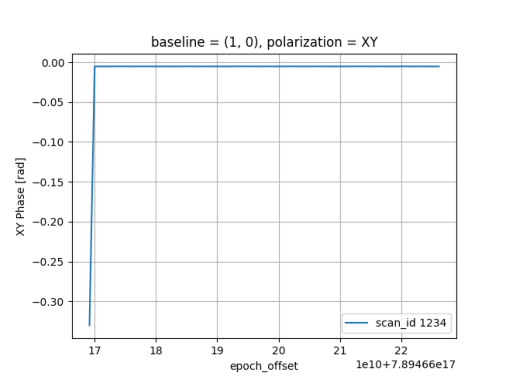

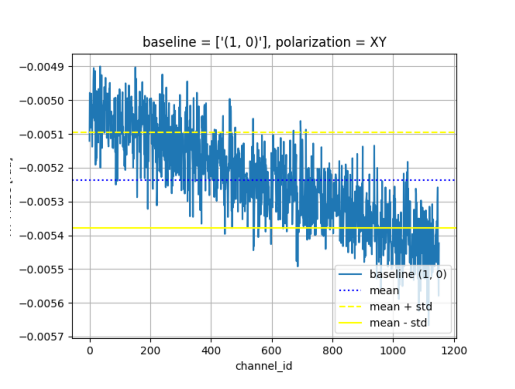

/mnt/cnic-data/20250106_080039_vis-via-tmc.pcap 133004980

Inspecting EB /mnt/cnic-data/20250106_080039_vis-via-tmc.pcap
2025-01-06 08:10:12,765 | INFO : Start reading SPEAD data from file: /mnt/cnic-data/20250106_080039_vis-via-tmc.pcap
2025-01-06 08:10:17,068 | INFO : Finished reading SPEAD data from file: /mnt/cnic-data/20250106_080039_vis-via-tmc.pcap
      ScaID  Chann  Epoch  ZoomI  VisFl  Resol SrcID  BeaID  Subar  Firmw  \
0      1235      0      0      0      0     32  b'L'      1      1  65536   
1      1235      1      0      0      0     32  b'L'      1      1  65536   
2      1235      2      0      0      0     32  b'L'      1      1  65536   
3      1235      3      0      0      0     32  b'L'      1      1  65536   
4      1235      4      0      0      0     32  b'L'      1      1  65536   
...     ...    ...    ...    ...    ...    ...   ...    ...    ...    ...   
1146   1235   1147      0      0      0     32  b'L'      1      1  65536   
1147   1235   1148      0 

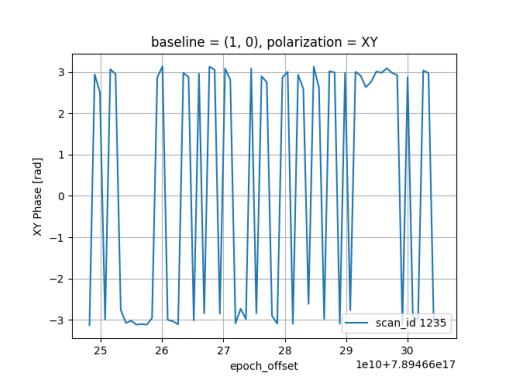

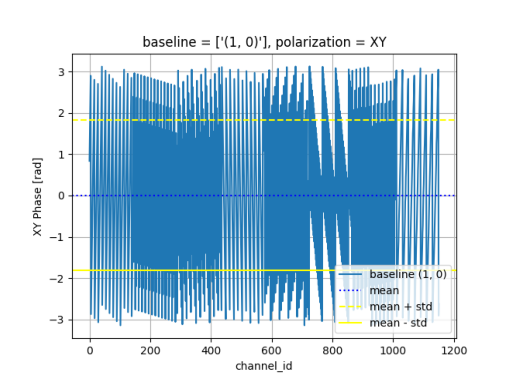

/mnt/cnic-data/20250106_080622_vis-via-tmc.pcap 461464699

Inspecting EB /mnt/cnic-data/20250106_080622_vis-via-tmc.pcap
2025-01-06 08:10:18,072 | INFO : Start reading SPEAD data from file: /mnt/cnic-data/20250106_080622_vis-via-tmc.pcap
2025-01-06 08:10:23,285 | INFO : Finished reading SPEAD data from file: /mnt/cnic-data/20250106_080622_vis-via-tmc.pcap
      ScaID  Chann  Epoch  ZoomI  VisFl  Resol SrcID  BeaID  Subar  Firmw  \
0      1237      0      0      0      0     32  b'L'      1      1  65536   
1      1237      1      0      0      0     32  b'L'      1      1  65536   
2      1237      2      0      0      0     32  b'L'      1      1  65536   
3      1237      3      0      0      0     32  b'L'      1      1  65536   
4      1237      4      0      0      0     32  b'L'      1      1  65536   
...     ...    ...    ...    ...    ...    ...   ...    ...    ...    ...   
1146   1237   1147      0      0      0     32  b'L'      1      1  65536   
1147   1237   1148      0 

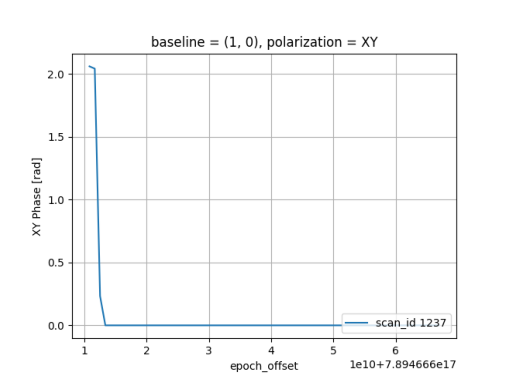

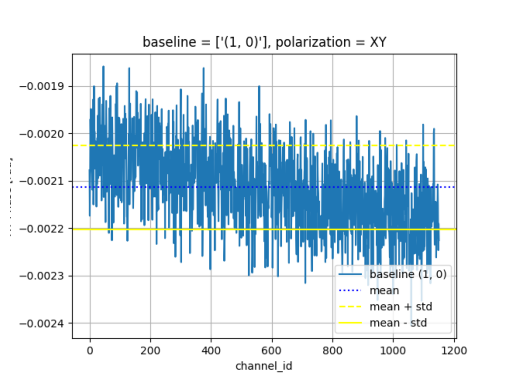

In [129]:
for idx, CNIC_RX_PCAP_FILE_PATH in enumerate(vis_pcap_files):
    filename = CNIC_RX_PCAP_FILE_PATH.replace("/test-data", PATH_TO_PCAP_DISK)
    print(filename, os.path.getsize(filename))
    if os.path.getsize(filename) < 100:  # bytes
        print(f"File {filename} contains no data")
    else:
        print(f"\nInspecting EB {filename}")
        pcap_output = visibilities.unpack_pcap_file(filename)
        print(pcap_output.metadata)  # pylint: disable=pointless-statement
        scan_ids = np.unique(pcap_output.metadata['ScaID'])
        print(pcap_output.data)  # pylint: disable=pointless-statement
        basic_display(pcap_output, scan_ids)